(page:cna)=
# Common Neighbor Analysis

This script performs a Common Neighbor Analysis. CNA was originally introduced by Honeycut and Andersen ([J. Phys. Chem., 1987, 91, 4950–4963](https://pubs.acs.org/doi/pdf/10.1021/j100303a014)). Here, we use the triples definition implemented by Clarke and Jónsson ([Phys. Rev. E, 1993, 47, 3975–3984](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.47.3975)). A first draft of this code was contributed by Julian Bessner (Ulm University).

As usual, we start by reading in the data.

In [1]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Select a non-oxidized system with 0 oxygen atoms.

In [2]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 0)].iloc[0]
atoms = read_bgf(sample["root"])

Similar to the [classical coordination number analysis](page:cns) and the [generalized coordination number analysis](page:gcns), this method analyzes the coordination environment of atoms. A cutoff parameter is required to determine if atoms are neighbors or not. Here, we use the same cutoff value $r_c$ that served us well in the other implementations.

In [3]:
rc = 3.0

To start off, we require a neighbor list. We will reuse the implementation from the [generalized coordination number analysis](page:gcns). We could also implement the `probe` parameter here to filter the indices but since CNA is mostly used on [single-element systems](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.47.3975), we leave it out this time.

In [4]:
neighborList = {}
indices = [atom.index for atom in atoms]
for idx in indices:

    # Calculate all distances.
    dists = atoms.get_distances(idx, indices)

    # Initialize empty list for current atom index.
    neighborList.update({idx: []})

    # Add indices of neighbor atoms to the list.
    for i, d in enumerate(dists):
        if d > 0 and d <= rc:
            neighborList[idx].append(indices[i])

Now start building the list of $jkl$ triples. The $jkl$ indices stand for:

* $j$: Number of common neighbors of two atoms.
* $k$: Number of bonds between these common neighbors.
* $l$: Longest chain of connected common neighbors.

The nested loops we are about to build are likely to become visually confusing, so we first section off code into two separate function to improve legibility of the code.

The first function finds $k$, which is the number of bonds between common neighbors of the current pair of atoms. The common neighbors are supplied as a list via the `common` argument.

In [5]:
def findConnected(common, atoms, rc):
    """Determine number of bonds between common neighbors."""
    connected = []
    for i, commonAtom1 in enumerate(common[:-1]):
        # commonAtom are atomic indices which relate back to the
        # original atoms list.
        for commonAtom2 in common[i + 1:]:
            dist = atoms.get_distance(commonAtom1, commonAtom2)
            if dist <= rc:
                # Adding tuples of (commonAtom1, commonAtom2)
                # to connected list.
                connected.append((commonAtom1, commonAtom2))
    return connected

The `findConnected` function makes use of `ase.Atoms.get_distance` again which can be supplied with the `mic = True` keyword to make this function work properly for periodic systems such as crystals.

The second function is used to find $l$, the longest connected chain of bonds within a given list of common neighbor atoms. As input it receives the output of the previous function, a list called `common`, which contains the number of bonds between common neighbors.

In [6]:
from itertools import combinations

def maxBondChain(connected):
    """Calculate the longest connected chain of connected bonds."""
    listMaxBondChain = []
    for i, j in combinations(connected, 2):
        if (i[0]  == j[0] or i[0] == j[1] or i[1] == j[0] or i[1] == j[1]):
            listMaxBondChain.extend([i, j])
        elif (i[0] != j[0] and i[0] != j[1] and i[1] != j[0]
                and i[1] != j[1]):
            listMaxBondChain.append(i)
        else:
            continue
    return len(set(listMaxBondChain))

The next cell performs the actual calculation of $jkl$ in a nested `for` loop. The first `for` loop selects each atom. The nested, inside `for` loop then iterates through its neighbor atoms. We explicitly calculate $j$ in the first section of the inner loop as the intersection between the `neighborLists` of `atom1` and `atom2`. For the calculation of $k$ and $l$, the functions defined above are called to reduce the visual clutter in this loop.

In [7]:
jklList = {}
for atom1, neighbors1 in neighborList.items():
    for atom2 in neighbors1:

        # Find intersection of neighbor lists. This gives us the j of
        # the (jkl) triple.
        neighbors2 = neighborList[atom2]
        common = list(set(neighbors1) & set(neighbors2))
        j = len(common)

        # Next, find number of bonds between these common neighbors
        # This gives us the k of the (jkl) triple.
        connected = findConnected(common, atoms, rc)
        k = len(connected)

        # Find the longest chain of connected common neighbors of the pair.
        # This gives us l of the (jkl) triple.
        l = maxBondChain(connected)

        # Insert to jkl dictionary.
        jklList.update({atom1: (j, k, l)})

`jklList` now contains an entry for each pair of neighboring atoms. We are, however, more interested in the distributions of $jkl$ for the entire system. Loop through `jklList` and count how often each $jkl$ triple occurs.

In [8]:
jklDist = {}
for jkl in jklList.values():
    if jkl != (0, 0, 0):
        if jkl not in jklDist:
            jklDist.update({jkl: 1})
        else:
            jklDist[jkl] += 1

Finally, visualize the distribution. Here, we overwrite the `xticks` list of the `pyplot` figure with the names of the $jkl$ triples to make those into the $x$ axis.

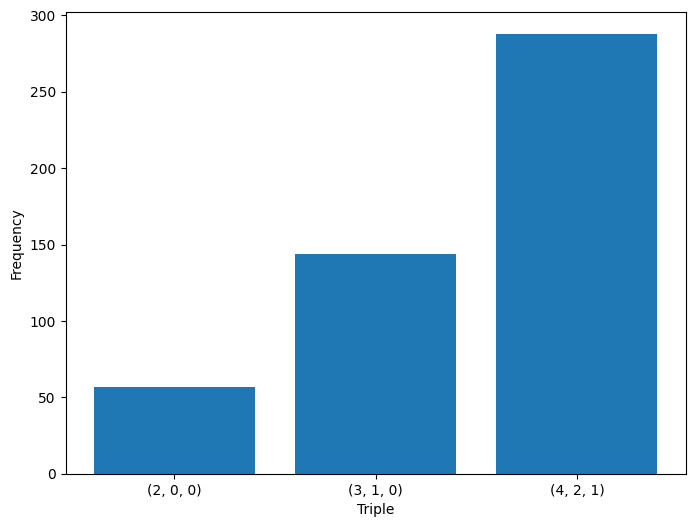

In [9]:
import matplotlib.pyplot as plt

xticks = []
y = []
x = range(len(jklDist))
for triple, frequency in sorted(jklDist.items()):
    xticks.append(str(triple))
    y.append(frequency)
plt.figure(figsize=(8, 6))
plt.xticks(x, labels=xticks)
plt.xlabel("Triple")
plt.ylabel("Frequency")
plt.bar(x, y)
plt.show()

The results are in line with expectations from [literature](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.47.3975). The script finds that the (4,2,1) triple has the highest frequency, which correctly identifies the fcc Pt lattice that the particle was cut from. The (3,1,0) triple, which is not present in perfect bulk fcc Pt, is found here as well and corresponds to the undercoordinated facet and edge sites. The (2,0,0) triple characterizes the vertices (tips) of the octahedron.